In [24]:
import os
import pandas as pd
import numpy as np
from discrete_gm_nonpos import *

In [3]:
os.path.exists(os.getcwd() + "\\do-files\\MPI2023")

True

In [4]:
mpi2023 = pd.read_csv(os.getcwd() + "\\do-files\\MPI2023\\MPI2023_microdata.csv")

In [5]:
mpi2023.head()

,hhid,hh_d_ni_noasis,hh_d_esc_retardada,hh_d_logro_min,hh_d_destotalmax,hh_d_subocup_max,hh_d_10a17_ocup,hh_d_no_afil,hh_d_jubi_pens,hh_d_materialidad,...,upm,nvivi,nhoga,dpto,area,pobrezai,pobnopoi,ing_tcm,tcm,estgeo
0,00014_003_1,0,1,0,1,0,0,0,0,0,...,14,3,1,Asuncion,1,3,0,0.0,0,Asuncion
1,00014_020_1,0,0,0,0,0,0,1,0,0,...,14,20,1,Asuncion,1,3,0,0.0,0,Asuncion
2,00014_023_1,0,0,0,0,0,0,1,0,0,...,14,23,1,Asuncion,1,3,0,0.0,0,Asuncion
3,00014_024_1,0,0,0,0,0,0,0,0,0,...,14,24,1,Asuncion,1,3,0,0.0,0,Asuncion
4,00014_025_1,0,0,0,0,0,0,0,0,0,...,14,25,1,Asuncion,1,3,0,0.0,0,Asuncion


In [6]:
mpi2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17032 entries, 0 to 17031
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hhid                17032 non-null  object 
 1   hh_d_ni_noasis      17032 non-null  int64  
 2   hh_d_esc_retardada  17032 non-null  int64  
 3   hh_d_logro_min      17032 non-null  int64  
 4   hh_d_destotalmax    17032 non-null  int64  
 5   hh_d_subocup_max    17032 non-null  int64  
 6   hh_d_10a17_ocup     17032 non-null  int64  
 7   hh_d_no_afil        17032 non-null  int64  
 8   hh_d_jubi_pens      17032 non-null  int64  
 9   hh_d_materialidad   17032 non-null  int64  
 10  hh_d_hacinamiento   17032 non-null  int64  
 11  hh_d_sin_basur      17032 non-null  int64  
 12  hh_d_sin_salud      17032 non-null  int64  
 13  hh_d_agua_mejor     17032 non-null  int64  
 14  hh_d_san_mejor      17032 non-null  int64  
 15  hh_d_combus         17032 non-null  int64  
 16  fex_

In [7]:
dimensions_indicators = {
    "ed" : ["hh_d_ni_noasis","hh_d_esc_retardada","hh_d_logro_min"],
    "em" : ["hh_d_destotalmax","hh_d_subocup_max","hh_d_10a17_ocup","hh_d_no_afil","hh_d_jubi_pens"],
    "vi" : ["hh_d_materialidad","hh_d_hacinamiento","hh_d_sin_basur"],
    "sa" : ["hh_d_sin_salud","hh_d_agua_mejor","hh_d_san_mejor","hh_d_combus"]
}

In [8]:
def calculate_weights(mpi_indicators):
  """
  Parameters:
    mpi_indicators: dictionary

  Computation of each dimension and indicators weigths following capability approach criterion

  Returns two dictionaries: one with dimensions weigths and another with indicators weights
  """
  dim_weights, indic_weights = {}, {}
  for key in mpi_indicators.keys():
    weight = 1/len(mpi_indicators.keys())
    dim_weights[key] = weight
    for value in mpi_indicators[key]:
      indic_weights[value] = weight / len(mpi_indicators[key])
  return dim_weights, indic_weights

In [9]:
def deprivation_score(mpi_indicators,data):
    dimensions_weights, indicators_weights = calculate_weights(mpi_indicators)
    indicators_ = list(indicators_weights.keys())
    mpi_data = data[indicators_]
    #mpi_data = mpi_data.to_numpy()
    for indicator in mpi_data.columns:
        mpi_data[indicator] *= indicators_weights[indicator]
    score = mpi_data.sum(axis=1)
    return score

In [10]:
def censored_deprivation_score(deprivation_score, k):
  censored_deprivation_score = np.where(deprivation_score >= k, deprivation_score, 0)
  return censored_deprivation_score

In [11]:
c_k = censored_deprivation_score(deprivation_score(dimensions_indicators, mpi2023), 26/100)

C:\Users\girel\AppData\Local\Temp\ipykernel_33412\1372878469.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpi_data[indicator] *= indicators_weights[indicator]


In [12]:
mpi2023['mpi_poor'] =  np.where(c_k > 0, 1, 0)

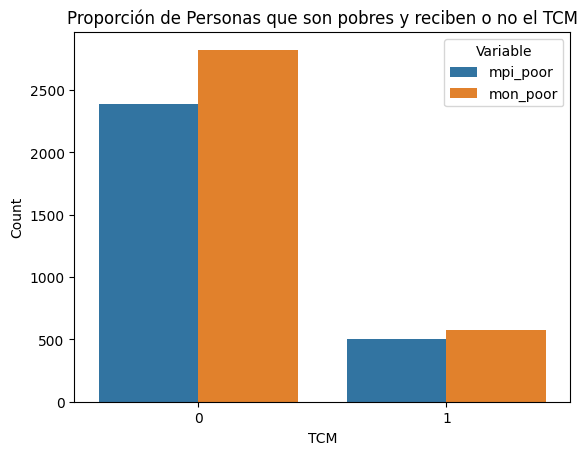

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

# Sample data (replace with your actual data)
data = {'TCM': mpi2023.tcm.to_numpy(),
        'MPI poor': mpi2023.mpi_poor.to_numpy(),
        'Monetary poor':  mpi2023['pobnopoi']}
df = pd.DataFrame(data)

grouped_counts = df.groupby('TCM').agg(
    mpi_poor=('MPI poor', 'sum'),
    mon_poor=('Monetary poor', 'sum')
)

# Create the grouped bar plot using seaborn
sns.barplot(x='TCM', y='value', hue='level_1', data=grouped_counts.stack().reset_index(name='value'))

# Customize the plot (optional)
plt.xlabel('TCM')
plt.ylabel('Count')
plt.title('Proporción de Personas que son pobres y reciben o no el TCM')
plt.legend(title='Variable')
plt.show()

In [17]:
pd.crosstab(mpi2023['pobnopoi'], mpi2023['mpi_poor'])

mpi_poor,0,1
pobnopoi,,
0,12083,1553
1,2056,1340


In [19]:
nested_indicators = list(dimensions_indicators.values())

indicators = []
for i in nested_indicators:
    indicators.extend(i)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [84]:
X = mpi2023[indicators]
Y = mpi2023['pobnopoi']

Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X,Y,train_size = 0.8, random_state=912)

In [85]:
# Discrete model
kfolds = 5
sdr=sdr_discrete_graphical_model(c=np.linspace(.1,1,10),ncores=4)
#cross_validation_in_prediction(sdr,X,Y,kfolds,AUC,bigger_is_better=True).learn_1fold(0)

In [86]:
ytrain = (ytrain > 0).to_numpy().reshape(-1,1).astype(int)>0
Xtrain = (Xtrain).to_numpy().astype(int)>0

In [ ]:
cross_validation_in_prediction(sdr,Xtrain,ytrain,kfolds,AUC,bigger_is_better=True).learn()# update sdr object

In [ ]:
print(sdr.c,sdr.ne,np.hstack((ytest, sdr.predict(Xtest))))

In [24]:
logr = LogisticRegression()
log_reg = logr.fit(Xtrain,ytrain)

In [25]:
log_reg.predict_proba(Xtest)

array([[0.92157269, 0.07842731],
       [0.93472285, 0.06527715],
       [0.42527378, 0.57472622],
       ...,
       [0.76931996, 0.23068004],
       [0.93472285, 0.06527715],
       [0.71305227, 0.28694773]])

In [32]:
rf = RandomForestClassifier(n_estimators=500)
random_forest = rf.fit(Xtrain, ytrain)

In [33]:
random_forest.predict_proba(Xtest)

array([[0.93437362, 0.06562638],
       [0.94812349, 0.05187651],
       [0.7888369 , 0.2111631 ],
       ...,
       [0.85357607, 0.14642393],
       [0.94812349, 0.05187651],
       [0.65953224, 0.34046776]])

In [34]:
ytest

7730     0
11773    1
14777    1
3278     1
2986     0
        ..
7394     0
11988    0
1870     0
13639    0
16042    1
Name: pobnopoi, Length: 3407, dtype: int64

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

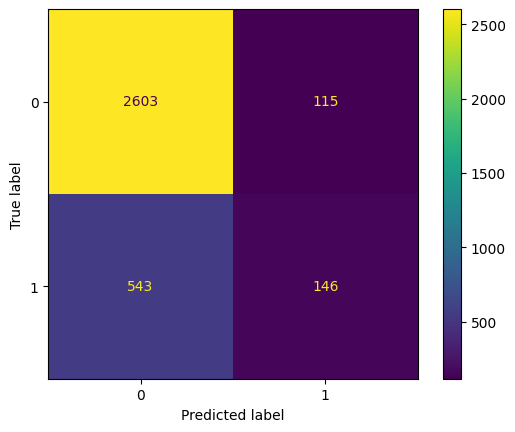

In [36]:
cm = ConfusionMatrixDisplay(confusion_matrix(ytest, random_forest.predict(Xtest)))
cm.plot()

In [37]:
print(classification_report(ytest, log_reg.predict(Xtest))),
print(classification_report(ytest, random_forest.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2718
           1       0.65      0.21      0.31       689

    accuracy                           0.82      3407
   macro avg       0.74      0.59      0.60      3407
weighted avg       0.79      0.82      0.78      3407

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2718
           1       0.56      0.21      0.31       689

    accuracy                           0.81      3407
   macro avg       0.69      0.58      0.60      3407
weighted avg       0.77      0.81      0.77      3407



In [39]:
def leakage(ytrue, ypred):
    tn, fp, fn, tp = confusion_matrix(ytrue, ypred).ravel()
    metric = fp/(fn+tp) 
    if metric > 1: metric = 1 
    return metric

def undercoverage(ytrue,ypred):
    tn, fp, fn, tp = confusion_matrix(ytrue, ypred).ravel()
    metric = fn/(fn+tp) 
    if metric > 1: metric = 1
    return metric

In [40]:
def evaluate_thresholds(probabilities, true_labels, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0, 1.01, 0.01)

    results = {
        'thresholds': [],
        'leakage': [],
        'undercoverage': []
    }

    for threshold in thresholds:
        predictions = (probabilities[:, 1] >= threshold).astype(int)
        leakage_error = leakage(true_labels, predictions)
        undercoverage_error = undercoverage(true_labels, predictions)

        results['thresholds'].append(threshold)
        results['leakage'].append(leakage_error)
        results['undercoverage'].append(undercoverage_error)
    
    return results
        

In [47]:
# Assuming you have probabilities and true_labels
results_rf = evaluate_thresholds(random_forest.predict_proba(Xtest), ytest)
results_lr = evaluate_thresholds(log_reg.predict_proba(Xtest),ytest)

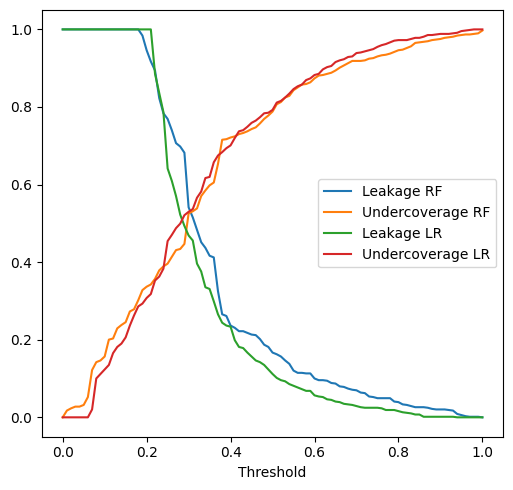

In [49]:
# Plot the results (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(results_rf['thresholds'], results_rf['leakage'], label='Leakage RF')
plt.plot(results_rf['thresholds'], results_rf['undercoverage'], label='Undercoverage RF')
plt.plot(results_lr['thresholds'], results_lr['leakage'], label='Leakage LR')
plt.plot(results_lr['thresholds'], results_lr['undercoverage'], label='Undercoverage LR')
plt.xlabel('Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
random_forest.predict_proba(Xtest)[:,1]

array([0.06562638, 0.05187651, 0.2111631 , ..., 0.14642393, 0.05187651,
       0.34046776])

In [78]:
random_forest.predict_proba(Xtest)

array([[0.93437362, 0.06562638],
       [0.94812349, 0.05187651],
       [0.7888369 , 0.2111631 ],
       ...,
       [0.85357607, 0.14642393],
       [0.94812349, 0.05187651],
       [0.65953224, 0.34046776]])

In [134]:
grouped_counts.stack().reset_index(name='value')

,TCM,level_1,value
0,0,mpi_poor,2391
1,0,mon_poor,2824
2,1,mpi_poor,502
3,1,mon_poor,572


In [132]:
grouped_counts

,mpi_poor,mon_poor
TCM,,
0,2391,2824
1,502,572
